# Preliminary Steps

We'll be using the statsmodel api for our data this week. To install the statsmodel package, activate your conda environment in your terminal and run conda install -c conda-forge statsmodels.

In [58]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

Here is the dataset we'll be working with today and its details: https://www.statsmodels.org/stable/datasets/generated/fair.html

In [59]:
# load dataset
affairs = sm.datasets.fair.load_pandas().data

# add "affair" column: 1 represents having affairs, 0 represents not
affairs['affair'] = (affairs.affairs > 0).astype(int)

In [60]:
affairs

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1
...,...,...,...,...,...,...,...,...,...,...
6361,5.0,32.0,13.0,2.0,3.0,17.0,4.0,3.0,0.000000,0
6362,4.0,32.0,13.0,1.0,1.0,16.0,5.0,5.0,0.000000,0
6363,5.0,22.0,2.5,0.0,2.0,14.0,3.0,1.0,0.000000,0
6364,5.0,32.0,6.0,1.0,3.0,14.0,3.0,4.0,0.000000,0


The goal of a logistic regression using this data is to see if we can successfully predict whether a woman will have an affair or not (which is why we created a boolean column for an affair).

# EDA

Let's check the difference in averages for those that had affairs and those that didn't. You can do this by grouping by the affairs column we made earlier and using the mean method.

In [61]:
# TODO
affairs.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


As we can see, those who had affairs tend to rate their marriage lower, spent longer married, etc. Make sure you understand what each value in each column means here!

Now, check the average values of each column grouped by rate_marriage.

In [62]:
# TODO
affairs.groupby('rate_marriage').mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
rate_marriage,,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


You should see three variables that increase as the marriage rating declines. What are they?

**Age, Years Married, Affairs**

# Visualizations

Out of curiosity, let's check the education level and frequency of each education level in the data.

<BarContainer object of 6 artists>

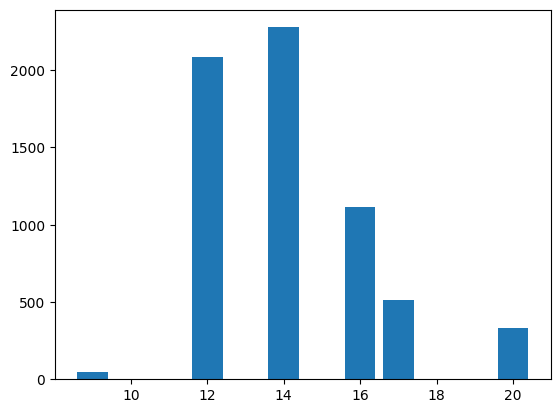

In [63]:
# TODO

education = affairs['educ'].value_counts().reset_index()
plt.bar(data=education,x='educ',height='count')



Create another histogram for marriage rating!

(array([  99.,    0.,  348.,    0.,    0.,  993.,    0., 2242.,    0.,
        2684.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

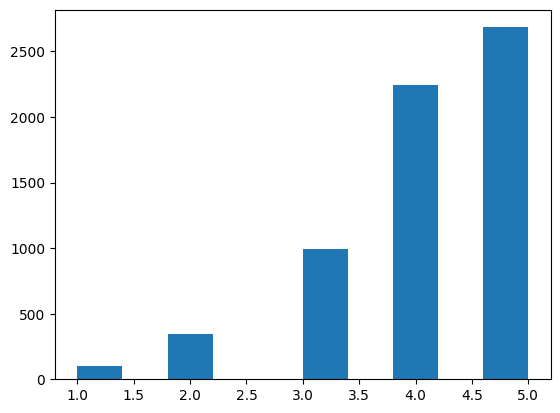

In [64]:
# TODO
plt.hist(data=affairs, x='rate_marriage')

Let's take a look at a more useful barplot still using marriage rating (organized by whether they had an affair or not). What do we learn from this?

Text(0, 0.5, 'Frequency')

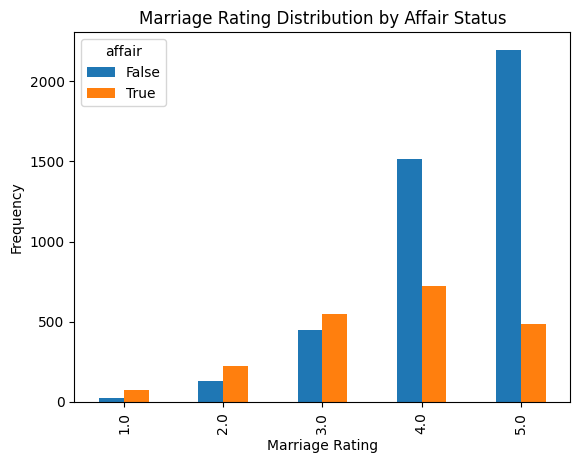

In [65]:
pd.crosstab(affairs.rate_marriage, affairs.affair.astype(bool)).plot(kind='bar')
plt.title('Marriage Rating Distribution by Affair Status')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Finally, let's take a look at the percentage of people who had affairs by the number of years they were married.

Text(0, 0.5, 'Percentage')

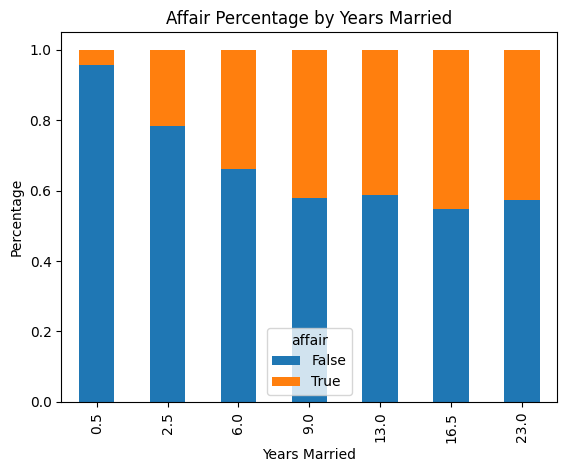

In [66]:
affair_yrs_married = pd.crosstab(affairs.yrs_married, affairs.affair.astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Affair Percentage by Years Married')
plt.xlabel('Years Married')
plt.ylabel('Percentage')

Interpret this graph. What does this mean/tell us?

**Near the beginning, we see an increase in affairs as the years of marriage increases. After 9 years, the amount of affairs stays relatively constantly. This means that in the first decade of marriage, we see a constant increase in affairs happening the longer a couple is married, which is not good.**

# Logistic Regression Prep

Let's import some necessary packages first. <br>
If you don't have sklearn installed, use conda install scikit-learn in your conda environment

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

We saw that occupation and occupation_husb are technically categorical variables describing the type of job each person has. We would like to include it as a predictor variable, but it would not make sense to use it in a continuous numerical variable (since each number is a category). Therefore, we must make these columns into dummy variables (if you're confused on any of this, ask us questions!)

In [68]:
affairs

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1
...,...,...,...,...,...,...,...,...,...,...
6361,5.0,32.0,13.0,2.0,3.0,17.0,4.0,3.0,0.000000,0
6362,4.0,32.0,13.0,1.0,1.0,16.0,5.0,5.0,0.000000,0
6363,5.0,22.0,2.5,0.0,2.0,14.0,3.0,1.0,0.000000,0
6364,5.0,32.0,6.0,1.0,3.0,14.0,3.0,4.0,0.000000,0


If we try using the [get_dummies()](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) method on our data, we'll notice that it doesn't work as expected (dimensions of our data are the same!)

In [69]:
pd.get_dummies(affairs)

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1
...,...,...,...,...,...,...,...,...,...,...
6361,5.0,32.0,13.0,2.0,3.0,17.0,4.0,3.0,0.000000,0
6362,4.0,32.0,13.0,1.0,1.0,16.0,5.0,5.0,0.000000,0
6363,5.0,22.0,2.5,0.0,2.0,14.0,3.0,1.0,0.000000,0
6364,5.0,32.0,6.0,1.0,3.0,14.0,3.0,4.0,0.000000,0


This is because the data in the columns we want dummies for is a float. However, pd.get_dummies automatically converts categorical variables and not quantitative variables. To fix this, turn the columns of interest into strings to make it categorical. This is called one hot encoding.

In [72]:
# Create a new dataframe called ohc_affairs (ohc stands for One Hot Encoding) where we have all the same data as before,
# but we have one hot encoded the categorical columns (read above to see which columns here are categorical)
# Use pd.get_dummies and use the documentation!
# Hint: You should have 32 columns after you do your one hot encoding

affairs['occupation'] = affairs['occupation'].astype(str)
affairs['occupation_husb'] = affairs['occupation_husb'].astype(str)
ohc_affairs = pd.get_dummies(affairs,columns=['educ','occupation','occupation_husb'])
ohc_affairs = ohc_affairs.replace({True: 1, False: 0})
ohc_affairs

/var/folders/hp/7cmzbgn97j721jhx0v8hg8sh0000gn/T/ipykernel_61374/3341472904.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ohc_affairs = ohc_affairs.replace({True: 1, False: 0})


,rate_marriage,age,yrs_married,children,religious,affairs,affair,educ_9.0,educ_12.0,educ_14.0,...,occupation_3.0,occupation_4.0,occupation_5.0,occupation_6.0,occupation_husb_1.0,occupation_husb_2.0,occupation_husb_3.0,occupation_husb_4.0,occupation_husb_5.0,occupation_husb_6.0
0,3.0,32.0,9.0,3.0,3.0,0.111111,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,3.0,27.0,13.0,3.0,1.0,3.230769,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,4.0,22.0,2.5,0.0,1.0,1.400000,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,4.0,37.0,16.5,4.0,3.0,0.727273,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,5.0,27.0,9.0,1.0,1.0,4.666666,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6361,5.0,32.0,13.0,2.0,3.0,0.000000,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
6362,4.0,32.0,13.0,1.0,1.0,0.000000,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
6363,5.0,22.0,2.5,0.0,2.0,0.000000,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
6364,5.0,32.0,6.0,1.0,3.0,0.000000,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


# Logistic Regression

Now that we have our variables let's test our model before using a train/test split.

In [77]:
# TODO
y = affairs['affair']
X = affairs.drop(columns=['affair'])

Create an sklearn LogisticRegression object and fit it to your design matrix X and your target feature y.

In [78]:
# TODO
model = LogisticRegression(max_iter=1000)
model.fit(X, y)

LogisticRegression(max_iter=1000)

Find your model score using the score() method of the LogisticRegression object.

In [80]:
# TODO
model.score(X,y)

0.9783223374175306

This accuracy seems high, but we need to check something called the null error rate. The null error rate is the accuracy we would get by only guessing one type of answer (in this case, if we only guessed that a person would not have an affair).

In [84]:
# TODO
null_error_rate = (y == y.mode()[0]).mean()
null_error_rate

np.float64(0.6775054979579014)

So 32% of women had affairs, meaning 68% of women did not have affairs. Our null error rate is 68%, meaning we could guess accurately 68% of the time by only predicting that they would not have an affair. Our model is better than this rate only by a slight amount.

Let's check the coefficients of each variable to see what kind of patterns we get.

In [85]:
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,rate_marriage,[-0.43889801538397083]
1,age,[-0.07852081870895221]
2,yrs_married,[0.16119238607918934]
3,children,[0.053199216575824396]
4,religious,[-0.23332161089500955]
5,educ,[0.01505134096335645]
6,occupation,[0.07690239053014453]
7,occupation_husb,[0.026278292916855774]
8,affairs,[18.81675343211765]


What kind of information can we get from this? I.e. are there certain variables that have a factor in decreasing the likelihood of an affair? Are there variable that increase the likelihood? Think about what it means in this case for a coefficient to be positive or negative.

**From this, we can see the with more years of marriage leads to a higher likelihood of an affair. With religion and marriage rate increasing, having an affair will decrease.**

Now time to add in training/testing for a more accurate model.

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression(max_iter=3000)
# TODO
model2.fit(X_train, y_train)
# train your model

LogisticRegression(max_iter=3000)

In [90]:
# TODO 
# predict class labels for the test set
predicted = model2.predict(X_test)

Now let's check the accuracy of our model by comparing the values we predict to the actual ones.

In [91]:
print(metrics.accuracy_score(y_test, predicted))

0.9785340314136126


Cool, our model is pretty good because even after test/training we see that accuracy is slightly higher but still around 73%.

Now let's get a confusion matrix to see how we did on an individual prediction level. Interpret this below (remember there is a slide on this!). Specifically, what is the TPR and FPR and what do each of the four values mean in the context of this question?

In [92]:
print(metrics.confusion_matrix(y_test, predicted))

[[1303    0]
 [  41  566]]


**The True Positive Rate is around 0.9324 and the False Positive Rate is 0. Positive would be predicting that there was an affair and False would mean there is no affair. This confusion matrix shows when a couple has an affair, we are able to accurately predict them having an affair 93% of the time. When a couple actually doesn't have an affair, we have predicted that accurately everytime. 

Next up is something called a classification report, which basically tells us how accurate our model is. This goes off the confusion matrix with 3 important things: "Precision", which tells us how many people were predicted to have an affair that actually did; "Recall", which tells us the percent of people that actually had an affair and were correctly predicted; and "F1 Score", which combines these two metrics to give us a measure of our model accuracy (closer to 1 is more accurate). "Support" just tells us the count for each variable.

In [94]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1303
           1       1.00      0.93      0.97       607

    accuracy                           0.98      1910
   macro avg       0.98      0.97      0.97      1910
weighted avg       0.98      0.98      0.98      1910



### EXTRA
Run the below code to see what your model is actually outputting behind the scenes. Notice how it doesn't output 1 and 0 like our predict method but instead it outputs probabilities. sklearn's LogisticRegression object automatically classifies something as a 1 if the probability is >= 0.5.
<br>
<br>
If you want to learn more about how logistic regression works, go to the advanced classification model supplemental lecture!


In [95]:
probs = model2.predict_proba(X_test)[:, 1]
probs

array([0.08530812, 0.00974651, 0.02916643, ..., 0.04732304, 0.01526871,
       1.        ], shape=(1910,))

Now try using sklearn's decision tree classifier and compare the score to your logistic regression.

In [96]:
from sklearn import tree

In [101]:
clf = tree.DecisionTreeClassifier()
# TODO
# train your decision tree and check the accuracy using the score method
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

1.0